# Timepix3 Parser prototype

This notebook demonstrates how to parse a particular Timepix3 raw event stream file, found at https://zenodo.org/record/3635923. The data used were those under `experimental_200kv/edge/edge1_000001.tpx3`.

The decoding logic and file structure were inferred from (and heavily inspired by) the repository https://github.com/M4I-nanoscopy/tpx3HitParser and in particular the file https://github.com/M4I-nanoscopy/tpx3HitParser/blob/master/tpx3format/read.py.

## The file format
The file is encoded as a sequence of little-endian longlong unsigned integers (`np.uint64`) each of which encodes either a header packet or a data packet via bit-packing. Header packets have the following structure:

In [5]:
import ctypes

class HeaderPacket_bitfield(ctypes.LittleEndianStructure):
    _fields_ = [
        ("title", ctypes.c_char * 4),  # LSB
        ('chip_nr', ctypes.c_ubyte),
        ('mode', ctypes.c_ubyte),
        ('size', ctypes.c_ushort),  # MSB
    ]

with four fields:
- `title`: which is the literal `char[4]` array `TPX3`
- `chip_nr`: an integer in `(0, 1, 2, 3)` for the four timepix chips
- `mode`: presumably a chip mode flag, all the data seen so far are `mode == 0`
- `size`: uint16 number of bytes of payload following the header, `size % 8 == 0` is always True. 
  - In the data that I've seen I believe that `min(size) == 8` i.e. we always have at least one packet of payload even for control messages.


I'm using `ctypes.Structure` to decode the bytes in this notebook because it's compact notation that avoids doing a lot of bitshifting, and it also lets me look into the elements of an `np.array` as if they were decoded. As of right now I haven't figured out how to use this decoder in 'fast' or vectorized code, except for the obvious way which would be to write a C function to unpack the bits!
 
We can decode a header as such:

In [141]:
import numpy as np

class HeaderPacket(ctypes.Union):
    # Decodes .base as bitfield .b
    _fields_ = [
        ('base', ctypes.c_ulonglong),
        ('b', HeaderPacket_bitfield),
    ]
    
def bitfield_repr(obj, bf=None):
    """This is just for prettyprinting of bitfield objects"""
    if bf is None:
        bf = obj
    _repr = f'{obj.__class__.__name__.replace("_bitfield", "")}('
    for field in bf._fields_:
        name = field[0]
        try:
            value = getattr(obj.b, name)
        except AttributeError:
            value = getattr(obj, name)
        _repr = _repr + f'{name}={value}, '
    return _repr[:-2] + ')'
    
header = HeaderPacket()
# point the header object at a uint64 to give us the decoded view
header.base = np.uint64(58546808902144084)
print(bitfield_repr(header, bf=HeaderPacket_bitfield))

HeaderPacket(title=b'TPX3', chip_nr=3, mode=0, size=208)


A data packet for hit events is encoded as such:

In [38]:
c_ulong = ctypes.c_ulong
class EventsPacket_bitfield(ctypes.LittleEndianStructure):
    _pack_ = 1
    _fields_ = [
        # must use c_ulong for decoding here as the bitmask is not byte-aligned (?)
        # the true number of bits for each field in the bitmask is specified by the integers
        ("spidr", c_ulong, 16),  # LSB
        ("fine_toa", c_ulong, 4),
        ("tot", c_ulong, 10),
        ("coarse_toa", c_ulong, 14),
        ("pix", c_ulong, 3),
        ("super_pix", c_ulong, 6),
        ("col", c_ulong, 7),
        ("pkg_type", c_ulong, 4),  # MSB
    ]

    
class EventsPacket(ctypes.Union):
    _fields_ = [
        ('base', ctypes.c_ulonglong),
        ('b', EventsPacket_bitfield),
    ]

And we can get a view into an array of events like this:

In [30]:
arr = np.array((13322656592034140556, 13313702169348149644), dtype=np.uint64)
arr_b = arr.ctypes.data_as(ctypes.POINTER(EventsPacket_bitfield))

In [31]:
print(bitfield_repr(arr_b[0]))
print(bitfield_repr(arr_b[1]))

EventsPacket_bitfield(spidr=4492, fine_toa=6, tot=11, coarse_toa=5718, pix=1, super_pix=7, col=71, pkg_type=11)
EventsPacket_bitfield(spidr=4492, fine_toa=8, tot=21, coarse_toa=5718, pix=4, super_pix=7, col=70, pkg_type=11)


The fields in the packet are as such:

- `pkg_type`: identifies the package, this is `0xb == 11` for hit events
  - Other `pkg_types` in the upstream repo are:
     - `0x7`, control packet
     - `0x4`, heartbeat packet
     - `0x6`, TDC timestamp packet "TDC (Time to Digital Converter) packages can come from the external trigger"
  - For which some information exists in their decoder, but I haven't gone much into the details.
- `spidr`: this is the main time source, it is a 16-bit unsigned counter with a rollover time of 26.8435456 seconds (4.1 μs resolution)
- `coarse_toa` (u14-bit), `fine_toa` (u4-bit): these are extra bits of time resolution which are concatenated with `spidr` to give a 34-bit timestamp with the same rollover time (~1.5 ns resolution)
  - I believe `toa` stands for time-of-arrival
  - in the upstream decoder the two toa values are combined as `toa = (coarse_toa << 4) - fine_toa` to make an 18-bit counter
  - In the upstream code there are correction procedures for `toa` values depending on `chip_nr` and perhaps even row/column, I suppose to correct for phase differences due to trace lengths or particular chip characteristics.
 - `tot`: standing for 'time over threshold', a u10-bit counter, unknown units, representing 'intensity' of the hit event
 - `pix`, `super_pix`, `col`: represent the information used to compute the `x`/`y` position of the hit event for that chip reporting events. It seems that a single chip has a resolution of 256x256.
 
It seems to be that each header packet defines a payload linked to one chip, therefore I assume that all the hit events following a header belong to that chip.

## Timing and rollovers

A note on timestamps: in these raw files there seem to be no global timestamps attached to headers or events. There is only the single clock with the 26.8 second rollover (and this itself is possibly variable depending on if the camera is externally clocked, or if the clock has jitter or drift). It is possible that there is some kind of global timestamp in the other `pkg_types`(heartbeat or TDC package, perhaps) but I haven't seen it yet.

What this means is that we need to inspect the whole file at a coarse sampling to estimate the number of 26.8 second periods / rollovers that it contains, and add an offset to subsequent packets each time the counter rolls over.

## Parse some real events

In [32]:
import pathlib
data_path = pathlib.Path('./edge1_000001.tpx3')

In [35]:
memmap = np.memmap(data_path, mode='r', dtype=np.uint64)
print(memmap.shape)

(88797908,)


In [36]:
header.base = memmap[0]
print(bitfield_repr(header, bf=HeaderPacket_bitfield))

HeaderPacket(title=b'TPX3', chip_nr=2, mode=0, size=8)


Since this is the beginning of the file we haven't yet found any hit data, in fact this is a control packet as we will see if we try to decode the next item:

In [40]:
events = EventsPacket()
events.base = memmap[1]
print(bitfield_repr(events, bf=EventsPacket_bitfield))

EventsPacket(spidr=47388, fine_toa=12, tot=646, coarse_toa=0, pix=0, super_pix=0, col=16, pkg_type=7)


As we can see the `pkg_type` is 7 which is for a control packet. The rest of the data under this decoding should be considered invalid.

Let's fast-forward to the first data packet:

In [139]:
def generate_headers(array: np.ndarray, start_offset: int = 0) -> int:
    # Yields the absolute index in array of header values starting from start_offset
    header_view = array.ctypes.data_as(ctypes.POINTER(HeaderPacket_bitfield))
    
    offset = start_offset
    while offset < array.size - 1:
        if header_view[offset].title == b'TPX3' and header_view[offset].mode == 0:
            yield offset
            # Skip the payload
            offset += (header_view[offset].size // 8) #  the .size field is in bytes
        # Add one to seek onto the next item
        offset += 1

In [85]:
header_view = memmap.ctypes.data_as(ctypes.POINTER(HeaderPacket_bitfield))
events_view = memmap.ctypes.data_as(ctypes.POINTER(EventsPacket_bitfield))

for header_offset in generate_headers(memmap):
    if events_view[header_offset + 1].pkg_type == 0xb:
        break

print(f'Header at idx {header_offset}')
print(bitfield_repr(header_view[header_offset]))
print(bitfield_repr(events_view[header_offset + 1]))

Header at idx 200
HeaderPacket(title=b'TPX3', chip_nr=3, mode=0, size=648)
EventsPacket(spidr=125, fine_toa=15, tot=27, coarse_toa=13205, pix=0, super_pix=3, col=114, pkg_type=11)


which has the correct `pkg_type` of 11.


Sadly `numba` doesn't support nice `ctypes` bitfields/structs so we have to do a lot of manual bitshifting and bitmasking to decode using `numba` on an array of event integers:

In [103]:
import numba

@numba.njit
def parse_hit_data(hit_data: np.ndarray, chip_nr: int,
                   out_buffer: np.ndarray, cross_offset: int = 2):
    """
    Parse a 1D array of np.uint64 event packets into the (6, hit_data.size) np.uint16 out_buffer
    """
    col = (hit_data & np.uint64(0x0FE0000000000000)) >> np.uint64(52)
    super_pix = (hit_data & np.uint64(0x001F800000000000)) >> np.uint64(45)
    pix = (hit_data & np.uint64(0x0000700000000000)) >> np.uint64(44)
    parse_time_data_inplace(hit_data, out_buffer[3:6])
    # tot
    out_buffer[2] = ((hit_data >> np.uint64(16 + 4)) & np.uint64(0x3ff)).astype(np.uint16)
    convert_position_data(col.astype(np.uint16),
                          super_pix.astype(np.uint16),
                          pix.astype(np.uint16),
                          chip_nr,
                          out_buffer[0],
                          out_buffer[1],
                          cross_offset=cross_offset)


@numba.njit
def parse_time_data_inplace(hit_data: np.ndarray, out_buffer: np.ndarray):
    # spidr
    out_buffer[0] = np.bitwise_and(hit_data, np.uint64(0xffff))
    # coarse_toa
    out_buffer[1] = np.bitwise_and(hit_data >> np.uint64(16 + 14), np.uint64(0x3fff))
    # fine_toa
    out_buffer[2] = np.bitwise_and(hit_data >> np.uint64(16), np.uint64(0xf))


@numba.njit
def convert_position_data(col: np.ndarray,
                          super_pix: np.ndarray,
                          pix: np.ndarray,
                          chip_nr: int,
                          out_x: np.ndarray,
                          out_y: np.ndarray,
                          cross_offset: int = 2):
    # the x/y position values are for one chip so all np.uint8 (256x256 chip)
    # potential overflow issues here ?? probably impossible given the chip design
    out_x[:] = col + (pix >> np.uint16(2))
    out_y[:] = super_pix + (pix & np.uint16(0x3))
    combine_chips(out_x, out_y, chip_nr, cross_offset=cross_offset)

I've also added the code here to convert the per-chip x/y to the full sensor x/y. The parameter `cross_offset` pads the position values for chips `0, 1, 3` appropriately to account for the space between chips. In the upstream library the default `cross_offset == 2` giving a true sig_shape of (516, 516).

In [93]:
@numba.njit
def combine_chips(x: np.ndarray, y: np.ndarray, chip_nr: int, cross_offset: int = 2):
    """
    correction is applied inplace on x and y

    Chip are orientated like this (unspecified x/y orientation)
    2 1
    3 0
    """
    # Calculate extra offset required for the cross pixels
    offset = np.uint16(256 + 2 * cross_offset)
    size = np.uint16(255)

    if chip_nr == 0:
        x[:] += offset
        y[:] = size - y + offset
    elif chip_nr == 1:
        x[:] = size - x + offset
    elif chip_nr == 2:
        x[:] = size - x
    elif chip_nr == 3:
        y[:] = size - y + offset

Parse one block:

In [98]:
n_events = header_view[header_offset].size // 8
chip_nr = header_view[header_offset].chip_nr
first_event_idx = header_offset + 1
event_data = memmap[first_event_idx: first_event_idx + n_events]
out_buffer = np.empty((6, n_events), dtype=np.uint16)

print(f'Parsing {n_events} hits')
parse_hit_data(event_data, chip_nr, out_buffer)

Parsing 81 hits


Which gives the following structure (truncated):

In [102]:
import pandas as pd  # pd just for prettyprint
fields = 'x', 'y', 'tot', 'spidr', 'coarse_toa', 'fine_toa'
pd.DataFrame(data=out_buffer.T[:10], columns=fields)

,x,y,tot,spidr,coarse_toa,fine_toa
0,228,499,27,125,13205,15
1,229,500,18,125,13205,15
2,10,475,100,125,13205,15
3,10,476,62,125,13205,15
4,229,499,31,125,13205,15
5,228,500,52,125,13205,15
6,229,498,45,125,13205,15
7,30,479,5,125,13469,3
8,32,477,13,125,13470,15
9,24,487,20,125,13470,4


We can combine the three timestamps with the following function:

In [104]:
@numba.njit
def get_global_time_no_roll(spidr_time, coarse_toa, fine_toa):
    toa = (coarse_toa.astype(np.uint64) << np.uint64(4)) - fine_toa
    global_time = (spidr_time.astype(np.uint64) << np.uint64(18)) + toa
    return global_time

which must return `np.uint64` as we have 34 bits of resolution once combined.

In [105]:
global_timestamps = get_global_time_no_roll(out_buffer[3], out_buffer[4], out_buffer[5])

Plotting this we can see that the events are indeed out-of-order.

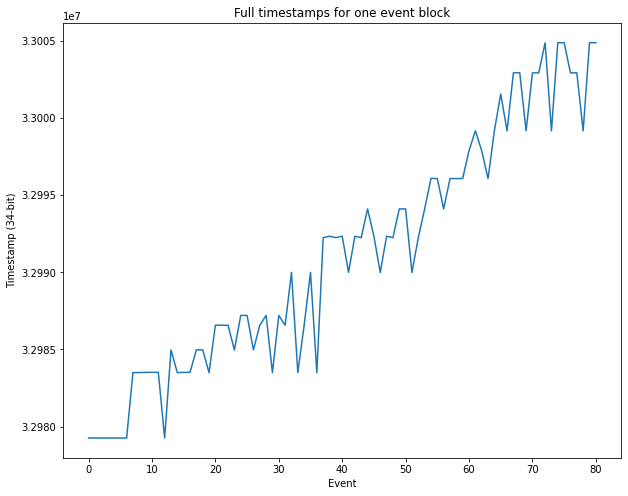

In [159]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(global_timestamps)
ax.set_title('Full timestamps for one event block');
ax.set_xlabel('Event');
ax.set_ylabel('Timestamp (34-bit)');

Note again that the timestamps here are not corrected for rollover, so we might find events with exactly the same timestamp much later in the file.

Depending on the dwell time it might be a reasonable assumption that all of the data in a single packet comes from a single scan point. This would reduce the complexity of sorting or filtering out-of-order / out-of-span data considerably, we could do it essentially on a per-header basis rather than a per-event basis!


## Parsing many events

If we parse many more events we can start to compile a frame. The parsing can be completely converted to `numba` functions (including finding headers) but here I stick to the Python generator for compactness.

In [142]:
total_events = 100_000

In [157]:
%%timeit
hits = []

for header_offset in generate_headers(memmap):
    if events_view[header_offset + 1].pkg_type == 0xb:
        n_events = header_view[header_offset].size // 8
        chip_nr = header_view[header_offset].chip_nr
        first_event_idx = header_offset + 1
        event_data = memmap[first_event_idx: first_event_idx + n_events]
        out_buffer = np.empty((6, n_events), dtype=np.uint16)
        
        parse_hit_data(event_data, chip_nr, out_buffer)
        hits.append(out_buffer)
        
        if sum(h.shape[1] for h in hits) > total_events:
            break

hits = np.concatenate(hits, axis=1)

70.1 ms ± 4.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


With a fully `numba`-fied parser performance was on the order of 1 million events in 20 ms on a single core.

In [116]:
hits.shape

(6, 100011)

We can do a rough check that there was no rollover in this period by inspecting the min/max spidr timers:

In [138]:
ROLLOVER_TIME = 26.8435456  # s

spidr_min, spidr_max = hits[3].min(), hits[3].max()
print(f'min {spidr_min}, max {spidr_max}, real_time ~ {ROLLOVER_TIME * (spidr_max - spidr_min) / 2**16:.3f} s')

min 125, max 153, real_time ~ 0.011 s


So on these data we had 100k events in 0.01 seconds and we were far from a rollover.

## Combining events

To create a sparse frame we need to combine hits on identical pixels so that we can sum the "intensity" or `tot` values. This is easier using flat indexes:

In [134]:
sig_shape = (516, 516) # +4 for cross/boundary pixels

flat_idcs = np.ravel_multi_index((hits[1], hits[0]), sig_shape)

Then we can combine the values using the following:

In [135]:
@numba.njit
def compress_hits(flat_idx: np.ndarray, tot: np.ndarray):
    unique_idcs = np.unique(flat_idx)
    mapping = np.searchsorted(unique_idcs, flat_idx)
    accumulators = np.zeros((unique_idcs.size,), dtype=np.uint64)
    accumulators[mapping] += tot
    return unique_idcs, accumulators

In [158]:
%%timeit
coords_flat, sum_tot = compress_hits(flat_idcs, hits[2])

20.1 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Which is not a cheap operation with this non-optimal implementation!

Now that we have the accumulated coordinates and intensities we can construct a COO sparse array:

In [137]:
import sparse

coords = np.stack(np.unravel_index(coords_flat, sig_shape), axis=0)
# sorted == True because the coordinates are the output of np.unique which always returns sorted values
sparse_frame = sparse.COO(coords, sum_tot, sorted=True, shape=sig_shape)

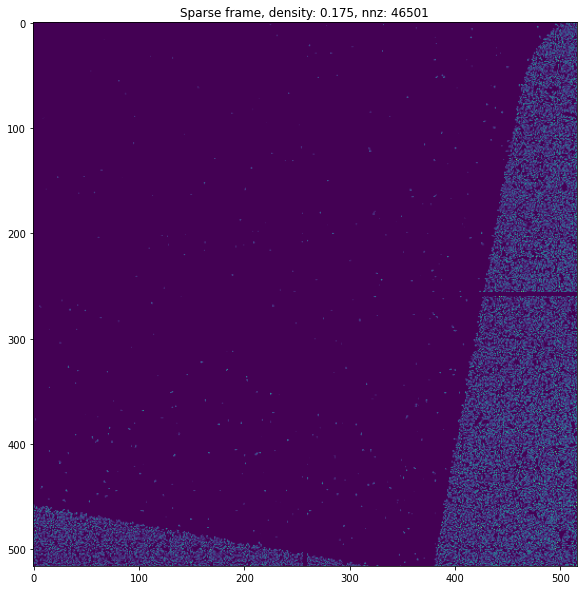

In [133]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(sparse_frame.todense());
ax.set_title(f'Sparse frame, density: {sparse_frame.density:.3f}, nnz: {sparse_frame.nnz}');

Note, in the upstream library there is also a correction step for the `ToT` values on a chip / row / column basis which I haven't implemented here. They also have a minimum `ToT` threshold to consider an event valid, by default they use `5`.

## Interpreting this in LiberTEM